In [1]:
!pip install gdrive_dataset

In [2]:
!pip install konlpy

In [3]:
!sudo apt-get install -y fonts-nanum #코랩 한글 폰트 꺠짐 방지 폰트 설치
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from konlpy.tag import Okt
from konlpy.tag import Komoran
from konlpy.tag import Kkma
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [5]:
from gdrivedataset import loader
file_id = '1IbyL1762M0Lgoq7_qm2RaXfl3ney0e9i'
loader.load_from_google_drive(file_id)
DATA_DIR = 'data/dataset'

========== files ============

data/dataset



In [6]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [7]:
train.head() #데이터 형태 확인

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [8]:
train.isna().sum() #결측치 확인

id          0
document    0
label       0
dtype: int64

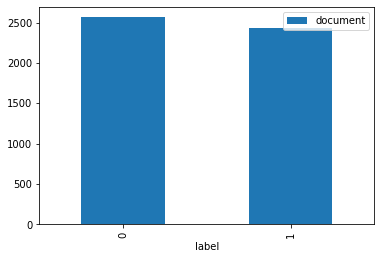

In [9]:
#id는 필요없는 속성이므로 제거해준다.
train = train.drop(['id'],axis=1)
train.groupby('label').count().plot.bar()

* 데이터의 비율이 일정하고 라벨링 또한 전부 돼있으므로 지도학습으로 접근한다.
* 분류 문제이므로 기본적인 로지스틱 회귀를 사용하거나 SVM을 활용합니다.

In [10]:
document = train['document'].str.replace('[^a-z|A-Z|ㄱ-ㅎ|가-힣|]','', regex=True)

In [11]:
#특수문자,불용어제거, 토큰화를 실행한다.
stop_words = ['의','가','이','은','들','는','걍','과','들','걍','과','으로','도','을','를','으로','자','에','와','한','하다','에서','에게'] #한글자로 구성된 토큰도 삭제해준다.
ok = Okt() #토크나이징을 실시한다.
kk = Kkma()
token_list = []
for sentence in document:
  token = ok.morphs(sentence,stem=True)
  if len(token) < 2: #못자르는 경우 kkma로 별도로 한번더 잘라줬습니다.
    token = kk.morphs(sentence)
    print(token)
  token = [t for t in token if t not in stop_words]
  if token: #텅빈 문장일 경우 추가하지 않습니다.
    token_list.append(token)

['veryveryverygood']
['revengeissweet']
['ItgetsbetterandbetterasitgoesonD']
['UnderworldAwakening']
['divorceDIVORCE']
['MirandaCosgroveABEST']
['수작']
['Itsastrangefilmisntit']
['대단', '하', '어요']
['producedbeChristopherNolan']
['Thuthisoutthere']
['굳']
['Nocomparisonsuperb']


In [12]:
tokens = pd.Series(token_list) #인덱싱을 위해 시리즈로 변환합니다.
tokens[:10]

0            [영상, 이나, 음악, 이쁘다, 도미, 화, 시키다, 불륜, 일, 뿐]
1                         [히치콕, 이영화, 보다, 분명, 박수, 치다]
2            [괜찮다, 음악, 영화, 또, 나오다, 따뜻하다, 겨울, 되다, 같다]
3           [아무래도, 년도, 지난, 작품, 이라, 지금, 보기, 너무, 유치하다]
4     [지금, 까지의, 영화, 그렇다, 영화, 역시, 일본, 대, 한미, 화, 여전하다]
5    [내, 인생, 있다, 손, 끄다, 락, 꼽히다, 영화, 원작, 능가, 리메이크, 작]
6                 [성룡, 영화, 중, 최악, 차라리, 러시아워, 훨씬, 나다]
7               [마음, 성숙하다, 보다, 다르다, 보이다, 영화, 걸작, 이다]
8                               [가슴, 찡하다, 기억, 남, 영화]
9                    [결말, 기분, 나쁘다, 공포, 매니아, 이따위, 결말]
dtype: object

In [13]:
freqeuncies = pd.Series(np.concatenate([w for w in token_list])).value_counts()
freqeuncies

영화        1353
보다        1098
없다         450
이다         375
좋다         355
          ... 
쩔뚝           1
롱롱롱          1
레지던트이블       1
바이크          1
차이다          1
Length: 7168, dtype: int64

In [14]:
def get_freq_count(tokens):
  pos_token = tokens[train['label'] == 1]
  neg_token = tokens[train['label'] == 0]
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq

def remove_doubled_words(pos_freq, neg_freq, tokens):
  #긍정,부정에서 모두 사용되는 단어는 의미 없는 단어이므로 제거해줍니다.
  top_50_pos = pos_freq[:20]
  top_50_neg = neg_freq[:20]
  remove_words = [p for p in top_50_pos.index if p in top_50_neg.index]
  tokens_removed = remove_stop_words(tokens, remove_words)
  final_tokens = cleaning_tokens(tokens_removed)
  return final_tokens

def draw_top_hist(data,name,color): #히스토그램을 그려줍니다.
  top_10 = data[:10]
  plt.figure(figsize=(12,7.5))
  plt.rc('font', family='NanumBarunGothic') 
  plt.suptitle("Bar Plot", fontsize=30)
  plt.title(name, fontsize=15)
  plt.bar(top_10.index,top_10.values, width=0.5, color= color, alpha=0.5)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [15]:
pos_freq, neg_freq = get_freq_count(tokens)

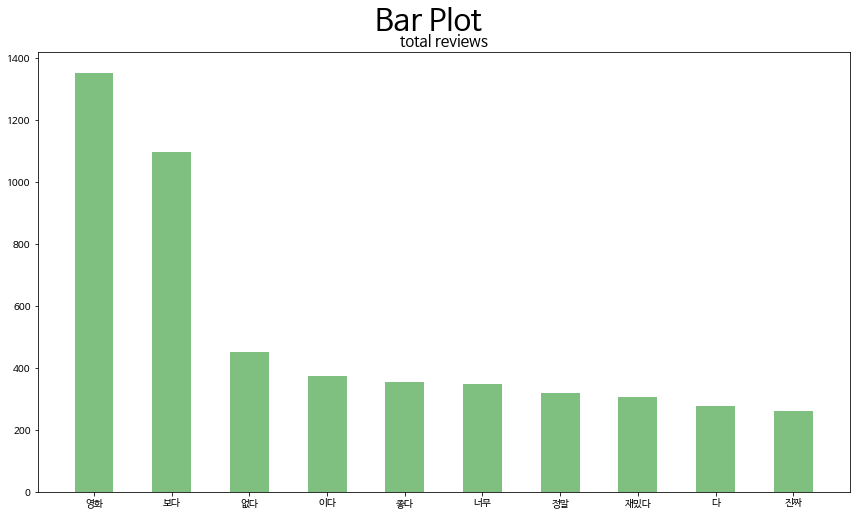

In [16]:
draw_top_hist(freqeuncies,'total reviews','g')

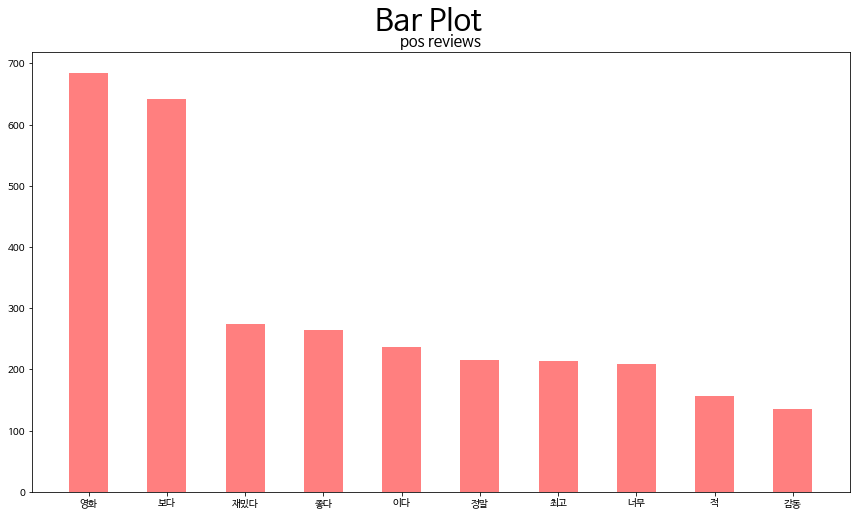

In [17]:
draw_top_hist(pos_freq,'pos reviews','r')

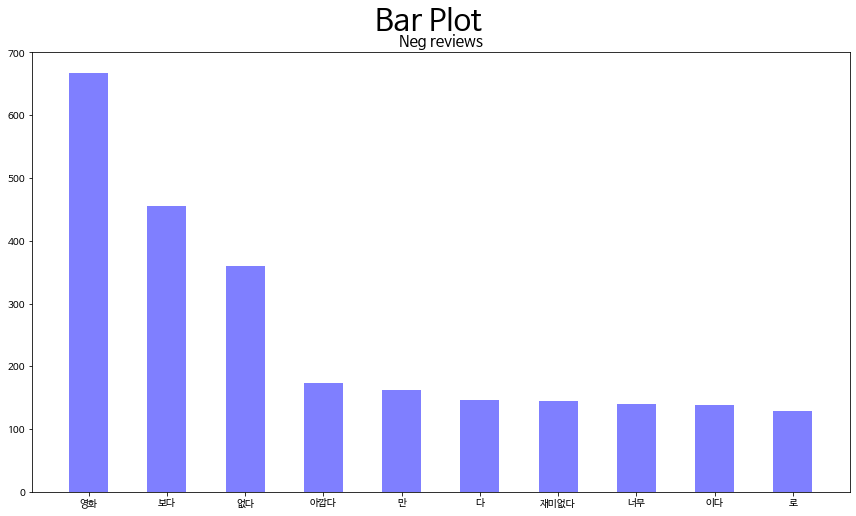

In [18]:
draw_top_hist(neg_freq,'Neg reviews','b')

겹치는 조사가 생각보다 많으니. 상위 10위에 공동으로 존재하는 토큰들은 전부 제거해줍시다.

In [19]:
top_50_pos = pos_freq[:10]
top_50_neg = neg_freq[:10]
common_words = [p for p in top_50_pos.index if p in top_50_neg.index]
common_words

['영화', '보다', '이다', '너무']

In [20]:
total = freqeuncies.sum()
common_words_cnt = freqeuncies[common_words].sum()
print(f'total words count: {total} removed: {common_words_cnt} ratio: {common_words_cnt / total :.2f}')

total words count: 40506 removed: 3174 ratio: 0.08


4만개의 사용횟수 중 8%정도의 빈도수가 겹치는 공통어였습니다. 이제 공통어들을 불용어로 처리해 제거해 줍니다.

In [21]:
clean_token_list = []
for token in tokens:
  clean_token = list(filter(lambda x: x not in common_words,token))
  clean_token_list.append(clean_token)

In [22]:
clean_tokens = pd.Series(clean_token_list)
clean_tokens[:10]

0        [영상, 이나, 음악, 이쁘다, 도미, 화, 시키다, 불륜, 일, 뿐]
1                         [히치콕, 이영화, 분명, 박수, 치다]
2            [괜찮다, 음악, 또, 나오다, 따뜻하다, 겨울, 되다, 같다]
3           [아무래도, 년도, 지난, 작품, 이라, 지금, 보기, 유치하다]
4         [지금, 까지의, 그렇다, 역시, 일본, 대, 한미, 화, 여전하다]
5    [내, 인생, 있다, 손, 끄다, 락, 꼽히다, 원작, 능가, 리메이크, 작]
6                 [성룡, 중, 최악, 차라리, 러시아워, 훨씬, 나다]
7                       [마음, 성숙하다, 다르다, 보이다, 걸작]
8                               [가슴, 찡하다, 기억, 남]
9                [결말, 기분, 나쁘다, 공포, 매니아, 이따위, 결말]
dtype: object

다시 긍,부정에서 많이 쓰이는 토큰 데이터를 확인해보자.

In [23]:
pos_freq,neg_freq = get_freq_count(clean_tokens)

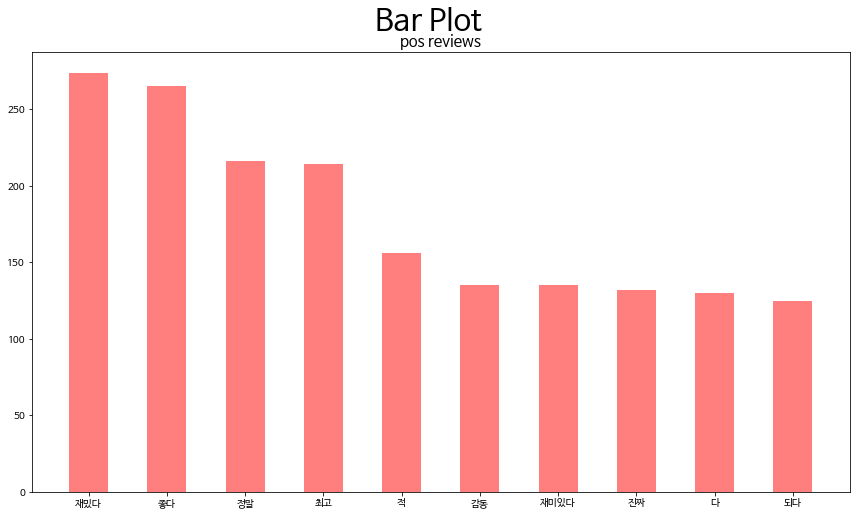

In [24]:
draw_top_hist(pos_freq,'pos reviews','r') #다시 그린 긍정리뷰 빈도수 히스토그램

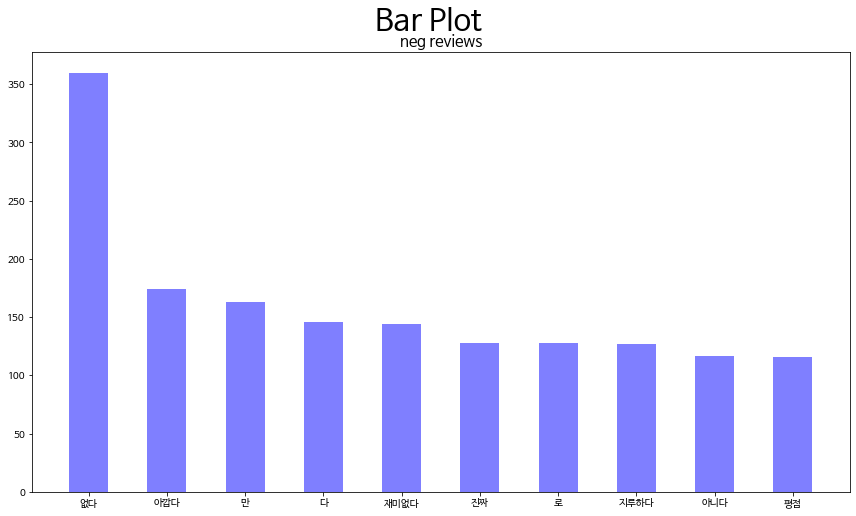

In [25]:
draw_top_hist(neg_freq,'neg reviews','b') #다시 그린 긍정리뷰 빈도수 히스토그램

* 공통으로 많이 사용하는 단어들을 제외하고 나니 부정과 긍정에서 사용하는 단어의 차이를 확인 할 수 있었습니다. 이제 벡터화를 진행해 봅시다. 
* 하지만 이전에 단어의 수에 대한 고민을 좀 해봅시다.


In [26]:
print(f"Words kinds: {len(freqeuncies)}")

Words kinds: 7168


* 단어의 사용 횟수는 4만번이고  7000개 정도의 단어를 사용하고 있습니다
* 정말 모든 단어를 사용해야만 할까요?


Text(0.5, 0.98, '6790 words explain 99.0% of total words dirtribution')

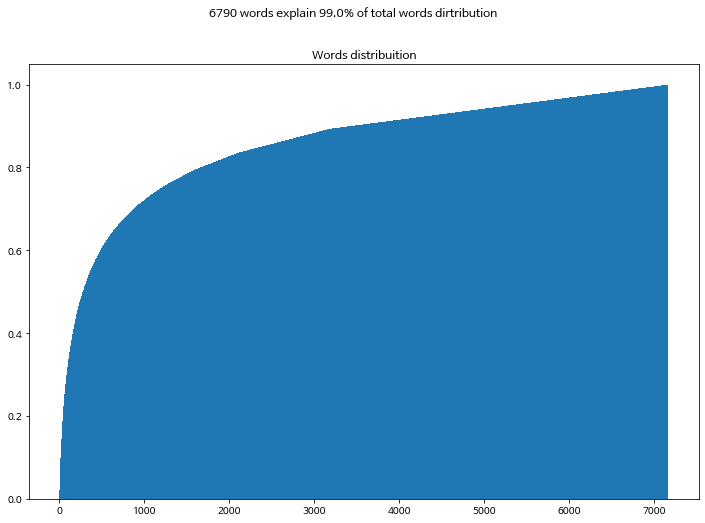

In [27]:
clean_frequencies = pd.Series(np.concatenate([w for w in clean_tokens])).value_counts()
accumulate_words = np.add.accumulate(clean_frequencies) #빈도수의 누적합을 구해줍니다.
ratio = 0.99
words_cnt = np.where(accumulate_words > sum(clean_frequencies) * 0.99)[0][0]
plt.figure(figsize=(12,8))
plt.bar(range(0,len(clean_frequencies)), accumulate_words / sum(clean_frequencies), width=1.0) #전체 단어와 현재까지의 빈도수의 비율을 구해줍니다.
plt.title('Words distribuition')
plt.suptitle(f'{words_cnt} words explain {ratio * 100:.1f}% of total words dirtribution')

* 99%의 빈도수를 설명하려면 6790개의 단어가 필요하다는 것을 확인했습니다. 
* 애초에 존재하던 단어의 수가 7000개 이므로 실상 차이가 나질 않습니다.
* 이제 왜 이런 결과과 나왔는지 단어 분포를 살펴봅시다.


No handles with labels found to put in legend.


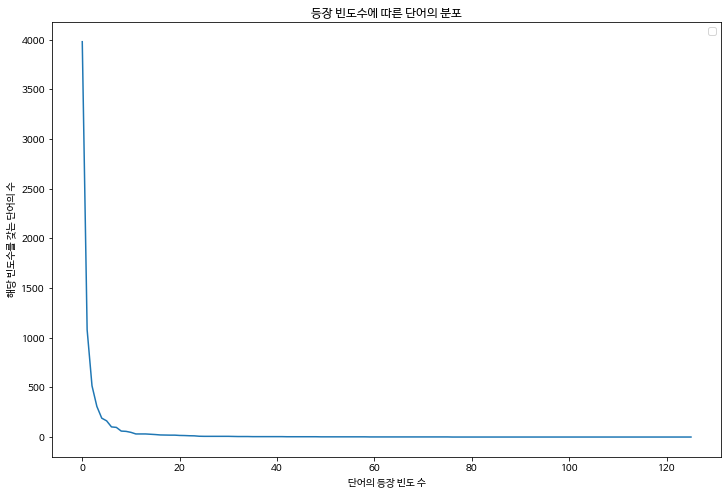

In [28]:
words_distribution = clean_frequencies.value_counts()
plt.figure(figsize=(12,8))
plt.plot(range(0,len(words_distribution)), words_distribution.values)
plt.ylabel("해당 빈도수를 갖는 단어의 수")
plt.xlabel("단어의 등장 빈도 수")
plt.title("등장 빈도수에 따른 단어의 분포")
plt.legend()

* 그래프를 살펴보면 빈도수가 높아질 수록 해당하는 단어의 수도 줄어든다는 것을 확인할 수 있습니다. 
* 빈도수가 낮은 단어의 수가 압도적으로 많으므로 단어 전체 분포를 설명하기 위해선 많은 단어가 필요합니다.

In [29]:
#tfidf를 활용해 벡터화를 진행합니다.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [30]:
X = clean_tokens.apply(''.join) #벡터화를 위해서 배열을 문자열로 합쳐줍니다.
y = train['label']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=2) #학습 데이터와 검증 데이터를 분리합니다.

In [31]:
#최적의 파라미터를 찾습니다.
best_max_feature = 0
best_cost = 0
best_f1 = 0
for i in range(100, 5000, 100): #max feature 값을 이동시키며 최적값을 찾습니다.
  vectorizer = TfidfVectorizer(analyzer='char',sublinear_tf=True,ngram_range=(1,3),max_features=i) 
  X_train_vector = vectorizer.fit_transform(X_train)
  X_eval_vector = vectorizer.transform(X_eval)
  for c in [0.01,0.03,0.1,0.3,1,3,10]: #cost 값을 이동시키며 최적 값을 찾습니다.
      lgs = LogisticRegression(class_weight = 'balanced', max_iter=2000, C = c)
      lgs.fit(X_train_vector, y_train)
      yhat = lgs.predict_proba(X_eval_vector)
      predicted = lgs.predict(X_eval_vector)
      f1 = f1_score(y_eval, predicted)
      accuracy = sum(predicted == y_eval) / len(predicted)
      if best_f1 < f1:
        print(f"Accuracy: {accuracy} f1-score: {f1}, max-features:{i}")
        best_max_feature = i
        best_cost = c
        best_f1 = f1

Accuracy: 0.692 f1-score: 0.6757894736842105, max-features:100
Accuracy: 0.699 f1-score: 0.687435098650052, max-features:100
Accuracy: 0.703 f1-score: 0.6966292134831461, max-features:100
Accuracy: 0.709 f1-score: 0.7039674465920651, max-features:100
Accuracy: 0.718 f1-score: 0.7134146341463414, max-features:100
Accuracy: 0.715 f1-score: 0.7147147147147147, max-features:100
Accuracy: 0.733 f1-score: 0.7289340101522843, max-features:200
Accuracy: 0.752 f1-score: 0.751503006012024, max-features:200
Accuracy: 0.761 f1-score: 0.7621890547263682, max-features:200
Accuracy: 0.766 f1-score: 0.7669322709163346, max-features:200
Accuracy: 0.77 f1-score: 0.7722772277227722, max-features:300
Accuracy: 0.778 f1-score: 0.7810650887573964, max-features:300
Accuracy: 0.777 f1-score: 0.7828627069133398, max-features:300
Accuracy: 0.788 f1-score: 0.7905138339920947, max-features:400
Accuracy: 0.796 f1-score: 0.799607072691552, max-features:400
Accuracy: 0.798 f1-score: 0.802348336594912, max-features:4

In [32]:
print(f"max_feature: {best_max_feature} cost: {best_cost} f1: {best_f1}") #최적의 파라미터

max_feature: 4300 cost: 10 f1: 0.871694417238002


In [33]:
vectorizer = TfidfVectorizer(analyzer='char',sublinear_tf = True, ngram_range=(1,3), max_features=best_max_feature) #최적의 파라미터를 기준으로 벡터화를 진행합니다.
X_train_vector = vectorizer.fit_transform(X_train)
X_eval_vector = vectorizer.transform(X_eval)
lgs = LogisticRegression(class_weight = 'balanced', max_iter=2000, C = best_cost)
lgs.fit(X_train_vector, y_train)
yhat = lgs.predict_proba(X_eval_vector)
yhat = yhat[:,1] #1인 경우의 확률만 구해줍니다.
predicted = lgs.predict(X_eval_vector)
f1 = f1_score(y_eval, predicted)
print(f"Accuracy: {lgs.score(X_eval_vector, y_eval)}")
print(f"f1-score: {f1}")

Accuracy: 0.869
f1-score: 0.871694417238002


* 로지스틱 회귀는 0.5를 기준으로 값을 분류합니다. 
* 하지만 이 기준을 조금 더 개선해 볼 수는 없을까요?
* 검증셋을 활용해 최적의 threshold를 찾아봅시다.

Best Threshold=0.501394, F-Score=0.872


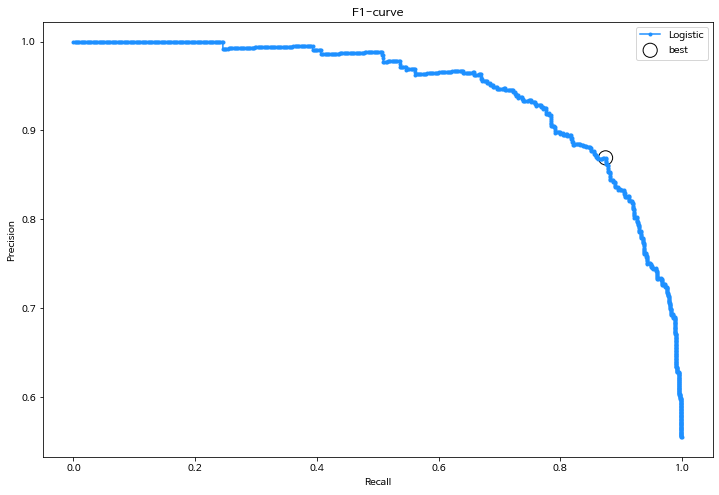

In [34]:
precisions,recalls,thresholds = precision_recall_curve(y_eval,yhat)
plt.figure(figsize=(12,8))
plt.plot(recalls, precisions, marker='.', label='Logistic', color='dodgerblue')
f1_score_list = (2 * precisions * recalls) / (precisions + recalls)
max_index = np.argmax(f1_score_list)
best_threshold = thresholds[max_index]
#s는 마커의 사이즈 facecolor는 마크의 내부 색상 edgecolor는 마크의 테두리 색상을 의미
plt.scatter(recalls[max_index],precisions[max_index],marker='o',color='black',label='best',s=200,facecolors='none',edgecolors='black')
plt.title('F1-curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold, f1_score_list[max_index]))

* 이제 새로 찾은 threshold 값을 활용해 다시금 라벨링을 진행합니다.

In [35]:
threshold = best_threshold
y_pred = np.where(yhat >= threshold,1,0)
f1 = f1_score(y_eval,y_pred,average='binary')
print(f"f1:{f1}")

f1:0.871694417238002


In [38]:
X_test = test['document']
X_test = vectorizer.transform(X_test) #test 데이터에 벡터화를 진행합니다.
pred = lgs.predict(X_test)

In [39]:
res = pd.DataFrame()
res['id'] = test['id']
tyhat = lgs.predict_proba(X_test)
tyhat = tyhat[:,1] #1인 경우의 확률만 구해줍니다.
ty_pred = np.where(tyhat >= best_threshold,1,0)
res['label'] = ty_pred

In [40]:
res.to_csv('result.csv',index=None)